In [1]:
# ==============================
# Libraries
# ==============================

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import time
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
import emcee
from multiprocessing import pool
import multiprocessing as mp
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Loading CC data
# =========================

# Path
cc_dat_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/CC/CC_Hz_data.txt"

# DataFrame
df_cc = pd.read_csv(cc_dat_path, sep=r"\s+")

# Main columns
z_cc   = df_cc["z_cc"].to_numpy(float)
H_obs  = df_cc["H_cc"].to_numpy(float)
H_err   = df_cc["H_cc_err"].to_numpy(float)

In [3]:
# ===================
# Fiducial
# ===================

# Uniform priors
H0_min, H0_max = 50., 90.
Om0_min, Om0_max = 0.1, 0.6
b_min, b_max = 1.6, 8.0

# Cosmological parameter
Or0 = 7.88e-5

# Scalaron mass scale
delta_s = 1e-7

# Scale facor grid
ai, af, n_p = 0.2, 1.0, 1000
a_grid = np.linspace(ai, af, n_p)

# Redshift grid
zi, zf = 0.0, 4.0
z_grid = np.linspace(zi, zf, n_p)

In [4]:
# ==============================
# Stable numerical functions
# ==============================

# Stable log(cosh(x))
def stable_logcosh(x):

    # Absolute value of x
    abs_x = np.abs(x)

    # Switch to asymptotic form for numerical stability
    if abs_x < 20:
        return np.log(np.cosh(x))
    else:
        return abs_x - np.log(2)


# Stable tanh(x)
def stable_tanh(x):

    # Asymptotic saturation for large |x|
    if x > 20:
        return 1.0
    elif x < -20:
        return -1.0
    else:
        return np.tanh(x)


# Stable sech(x)
def stable_sech(x):
    
    # Absolute value of x
    abs_x = np.abs(x)
    
    # Switch to asymptotic form for numerical stability
    if abs_x < 20:
        return 1.0 / np.cosh(x)
    else:
        return 2.0 * np.exp(-abs_x)


# ============================================================
# Curvature scale in the AB f(R) model
# ============================================================

def compute_epsilon(H0, b):
    
    # Vacuum curvature scale
    R_vac = 12.0 * H0**2

    # Stable evaluation of log(1 + exp(2b))
    if b < 20:
        L = np.log1p(np.exp(2.0 * b))
    else:
        L = 2.0 * b + np.exp(-2.0 * b)

    return R_vac / L

In [5]:
# ============================================================
# ODE system for the Hubble parameter in the AB model
# ============================================================

def Hubble_AB_a(a, y, H0, Om0, b):
    """
    System of ordinary differential equations for the Hubble
    parameter H(a) in the AB f(R) gravity model.

    The system evolves H and its first two derivatives with
    respect to the scale factor a.
    """

    # Hubble parameter and its 1st and 2nd derivatives 
    H, dH, ddH = y

    # Matter and radiation density parameters
    Om = Om0 * a**(-3)
    Or = Or0 * a**(-4)

    # Effective curvature scale from the AB model
    epsilon = compute_epsilon(H0, b)

    # Squadred scalaron rest mass
    M2 = epsilon / delta_s

    # Ricci (curvature) scalar
    R = 6.0 * H * (2.0 * H + a * dH)

    # Normalized curvature scalar shifted by the model parameter b
    alpha = (R / epsilon) - b

    # Numerically stable hyperbolic functions
    tanh_a = stable_tanh(alpha)
    sech_a = stable_sech(alpha)


    # ===============================
    # ODE terms : A, B, C, D, E, F
    # ===============================

    A = H0**2 * (3.0 * Om + 4.0 * Or)

    B = a * H * dH * (tanh_a + 1.0)

    C = ( 4.0 * a * H**2 * dH * (a * dH + 2.0 * H) / M2 )

    D = ( ((6.0 * a**2 * H**2) / epsilon)**2 * ((5.0 * dH / a) + (dH**2 / H) + ddH)**2 * tanh_a * (sech_a**2) )

    E = ( 6.0 * a**3 * H**3 * (1.0 / (3.0 * M2) + 0.5 * (sech_a**2) / epsilon) )

    # Avoid singularities and non-finite evolution
    if E == 0 or not np.isfinite(E):
        return [np.nan, np.nan, np.nan]

    F = ( (11.0 * dH**2) / (a * H) + (dH**3) / (H**2) + (6.0 * ddH / a) + (4.0 * dH * ddH / H) )


    # 3rd derivative of the Hubble parameter
    dddH = -( (A + B + C - D) / E) - F

    # Return 1st, 2nd, and 3rd derivatives of H
    return [dH, ddH, dddH]


In [6]:
# ============================================================
# ODE integration for obtaining H(a)
# ============================================================

def H_AB_a(a_grid, H0, Om0, b):
    """
    Numerical solution for the Hubble parameter H(a) in the
    AB f(R) gravity model.

    The integration is initialized at a = a_i using LCDM
    initial conditions and evolved up to a = a_f.
    """

    # ---------------------------------
    # Initial conditions according to the LCDM model at ai = 0.2
    # ---------------------------------
    
    # Initial matter and radiation density parameters
    Omi = Om0 * ai**(-3)
    Ori = Or0 * ai**(-4)

    # Cosmological constant density parameter
    Ol0 = 1.0 - Om0 - Or0

    # Initial Hubble parameter H(ai)
    Hi = H0 * np.sqrt(Omi + Ori + Ol0)

    # Initial 1st derivative dH/da at ai
    dHi = - ( (H0**2) / (2.0 * ai * Hi) ) * (3.0 * Omi + 4.0 * Ori)

    # Initial 2nd derivative d²H/da² at ai
    ddHi = ( 0.5 * (H0 / (ai * Hi))**2 * (Hi + ai * dHi) * (3.0 * Omi + 4.0 * Ori)
        + 0.5 * (H0 / (ai * Hi))**2 * Hi * (9.0 * Omi + 16.0 * Ori) )

    # Initial state vector
    y0 = [Hi, dHi, ddHi]

    
    # ---------------------------------
    # Numerical integration
    # ---------------------------------

    sol = solve_ivp(Hubble_AB_a, (ai, af), y0, t_eval=a_grid, method="LSODA", rtol=1e-6, atol=1e-9, args=(H0, Om0, b))

    # Check integration success and numerical validity
    if sol.status < 0 or np.any(~np.isfinite(sol.y)):
        return None

    # Return H(a) evaluated on the input grid
    return sol.y[0]

In [7]:
# ============================================================
# Conversion to H(z)
# ============================================================

def H_AB_z(z_grid, H0, Om0, b):
    """
    Compute the Hubble parameter H(z) in the AB model.

    The function internally converts the redshift grid z
    into a scale factor grid a = 1 / (1 + z), solves the
    differential system in a, and maps the solution back
    to the original redshift ordering.
    """
    
    # Convert redshift grid to scale factor grid
    a_grid = 1.0 / (1.0 + z_grid)

    # Sort scale factor for monotonic integration
    sort_idx = np.argsort(a_grid)
    a_sorted = a_grid[sort_idx]

    # Solve for H(a) on the sorted grid
    H_sorted = H_AB_a(a_sorted, H0, Om0, b)
    if H_sorted is None:
        return None

    # Restore original redshift ordering
    H_z = np.empty_like(H_sorted)
    H_z[sort_idx] = H_sorted

    return H_z


# ============================================================
# H(z) evaluated at CC data
# ============================================================

def H_AB_cc(z_cc, H0, Om0, b):
    """
    Evaluate the Hubble parameter H(z) in the AB model at the
    redshifts of Cosmic Chronometers data.

    The function computes H(z) on a reference redshift grid,
    performs a linear interpolation, and returns the model
    prediction at the Cosmic Chronometers redshifts.
    """

    # Compute H(z) on the reference grid
    H_grid = H_AB_z(z_grid, H0, Om0, b)

    # Check numerical validity of the solution
    if (H_grid is None or np.any(~np.isfinite(H_grid)) or np.any(H_grid <= 0)):
        return None

    # Interpolate H(z) and evaluate at CC redshifts
    H_interp = interp1d(z_grid, H_grid, kind="linear", fill_value="extrapolate")

    return H_interp(z_cc)


# ==========================
# Sanity test
# ==========================

print("H_AB(z_cc) =", H_AB_cc(z_cc, 70, 0.3, 2.5))

H_AB(z_cc) = [ 74.88574893  75.56360064  76.60895334  78.42914575  78.76722436
  79.53010198  79.56861387  82.36864977  82.78488835  85.9039575
  87.18416967  88.10285582  88.12155317  89.27178181  90.48088685
  91.48183203  91.89603623  91.98117919  97.91284909 102.83705491
 107.02001933 107.02001933 108.93412167 110.12577731 114.96395599
 115.29398866 116.6234467  126.11558748 142.89097368 146.05706808
 151.13249783 156.64439223 165.07901297 184.45192739 204.39139912]


In [8]:
# ================================
# Initial grid (coarse sampling)
# ================================

n_init = 7    # Number of points in the initial (coarse) grid
n_rfn = 10    # Number of points in the refined grid

def create_initial_grid(H0_range, Om0_range, b_range, n_H0=n_init, n_Om0=n_init, n_b=n_init):
    """
    Create a coarse uniform grid in the parameter space
    (H0, Omega_m0, b).
    """

    start = time.time()

    # Uniform sampling of each parameter
    H0_vals = np.linspace(*H0_range, n_H0)
    Om0_vals = np.linspace(*Om0_range, n_Om0)
    b_vals  = np.linspace(*b_range, n_b)

    # Timing information
    print(f"Initial grid {n_H0}×{n_Om0}×{n_b} created in {time.time()-start:.1f}s")

    # Return arrays of parameter values
    return H0_vals, Om0_vals, b_vals


# ================================
# Fast likelihood (used for grid refinement)
# ================================

def quick_loglike(H0, Om0, b):
    """
    Compute a fast log-likelihood using Cosmic Chronometers data.
    This is used only to identify the high-likelihood region
    of parameter space.
    """

    # Model prediction at CC redshifts
    H_theo = H_AB_cc(z_cc, H0, Om0, b)

    # Chi-squared
    chi2 = np.sum(((H_obs - H_theo) / H_err)**2)

    # Log-likelihood
    return -0.5 * chi2


# ================================
# Adaptive grid refinement
# ================================

def refine_grid(loglike_func, H0_vals, Om0_vals, b_vals, top_frac=0.2, n_refine=n_rfn):
    """
    Refine the parameter grid by selecting the top fraction
    of points with the highest likelihood and rebuilding
    a denser grid around them.
    """

    print("Refining grid...")
    start = time.time()

    # Array to store likelihood values on the coarse grid
    L = np.zeros((len(H0_vals), len(Om0_vals), len(b_vals)))

    total = L.size
    count = 0
    last_pct = 0

    # Evaluate likelihood on the full coarse grid
    for i, H0 in enumerate(H0_vals):
        for j, Om0 in enumerate(Om0_vals):
            for k, b in enumerate(b_vals):
                L[i, j, k] = loglike_func(H0, Om0, b)
                count += 1
                
                # Progress monitoring with estimated remaining time
                pct = int(count / total * 100)
                if pct >= last_pct + 10 or count == total:
                    elapsed = time.time() - start
                    eta = elapsed / count * (total - count)
                    print(f"{pct}% | elapsed {elapsed:.1f}s | ETA {eta:.1f}s")
                    last_pct = pct

    # Determine likelihood threshold corresponding to the top fraction
    L_flat = L.flatten()
    L_cut = np.percentile(L_flat, 100 * (1 - top_frac))

    # Containers for selected parameter values
    H0_sel, Om0_sel, b_sel = [], [], []

    # Select points above the likelihood threshold
    for i, H0 in enumerate(H0_vals):
        for j, Om0 in enumerate(Om0_vals):
            for k, b in enumerate(b_vals):
                if L[i, j, k] >= L_cut:
                    H0_sel.append(H0)
                    Om0_sel.append(Om0)
                    b_sel.append(b)

    # Build refined grids around the selected region
    H0_ref = np.linspace(min(H0_sel), max(H0_sel), n_refine)
    Om0_ref = np.linspace(min(Om0_sel), max(Om0_sel), n_refine)
    b_ref  = np.linspace(min(b_sel),  max(b_sel),  n_refine)

    # Timing information
    print(f"Refined grid {n_refine}³ created in {time.time()-start:.1f}s")

    # Return refined parameter grids
    return H0_ref, Om0_ref, b_ref


# ================================
# Build initial grid and perform refinement
# ================================

# Generate the initial coarse grid
H0_vals_init, Om0_vals_init, b_vals_init = create_initial_grid(
    (H0_min, H0_max),
    (Om0_min, Om0_max),
    (b_min, b_max),
    n_H0=n_init,
    n_Om0=n_init,
    n_b=n_init
)

# Refine the grid around the region of highest likelihood
H0_ref, Om0_ref, b_ref = refine_grid(
    quick_loglike,
    H0_vals_init,
    Om0_vals_init,
    b_vals_init,
    top_frac=0.2,
    n_refine=n_rfn
)


# ================================
# Compute H(z) on the refined 4D grid
# ================================

# Allocate array with dimensions (H0, Omega_m0, b, z)
H_array = np.zeros((len(H0_ref), len(Om0_ref), len(b_ref), len(z_grid)))

print("Calculating H(z) on the refined grid...")
start = time.time()

total = len(H0_ref) * len(Om0_ref) * len(b_ref)
count = 0
last_pct = 0

# Solve the cosmological equations for each point in parameter space
for i, H0 in enumerate(H0_ref):
    for j, Om0 in enumerate(Om0_ref):
        for k, b in enumerate(b_ref):
            H_array[i, j, k, :] = H_AB_z(z_grid, H0, Om0, b)
            count += 1

            # Progress monitoring
            pct = int(count / total * 100)
            if pct >= last_pct + 10 or count == total:
                elapsed = time.time() - start
                eta = elapsed / count * (total - count)
                print(f"{pct}% | elapsed {elapsed:.1f}s | ETA {eta:.1f}s")
                last_pct = pct

print(f"H_array completed in {time.time()-start:.1f}s")


# ================================
# 4D interpolator: H(H0, Om0, b, z)
# ================================

# Construct a 4D interpolator for fast evaluation of H(z)
H_interp_4D = RegularGridInterpolator(
    (H0_ref, Om0_ref, b_ref, z_grid),
    H_array,
    bounds_error=False,
    fill_value=None
)

Initial grid 7×7×7 created in 0.0s
Refining grid...
10% | elapsed 2.2s | ETA 19.7s
20% | elapsed 4.3s | ETA 17.3s
30% | elapsed 6.5s | ETA 15.1s
40% | elapsed 8.8s | ETA 13.1s
50% | elapsed 10.9s | ETA 10.9s
60% | elapsed 13.1s | ETA 8.7s
70% | elapsed 15.4s | ETA 6.5s
80% | elapsed 17.5s | ETA 4.3s
90% | elapsed 19.7s | ETA 2.2s
100% | elapsed 22.0s | ETA 0.0s
Refined grid 10³ created in 22.0s
Calculating H(z) on the refined grid...
10% | elapsed 6.5s | ETA 58.3s
20% | elapsed 13.0s | ETA 51.8s
30% | elapsed 19.4s | ETA 45.3s
40% | elapsed 25.9s | ETA 38.8s
50% | elapsed 32.3s | ETA 32.3s
60% | elapsed 38.8s | ETA 25.8s
70% | elapsed 45.2s | ETA 19.4s
80% | elapsed 51.7s | ETA 12.9s
90% | elapsed 58.2s | ETA 6.5s
100% | elapsed 64.7s | ETA 0.0s
H_array completed in 64.7s


In [9]:
# ================================
# Interpoled H(z)
# ================================

def H_AB_cc_interp(z_cc, H0, Om0, b):
    pts = np.column_stack([
        np.full_like(z_cc, H0),
        np.full_like(z_cc, Om0),
        np.full_like(z_cc, b),
        z_cc
    ])
    return H_interp_4D(pts)


# ==========================
# Sanity test
# ==========================

print("H_AB_cc_interp(z_cc) =", H_AB_cc_interp(z_cc, 70, 0.3, 2.5))

H_AB_cc_interp(z_cc) = [ 74.94610425  75.6245045   76.670527    78.49142674  78.82957849
  79.59255908  79.6310742   82.43080731  82.84692109  85.96447086
  87.24379099  88.16175117  88.18043318  89.32965794  90.53760198
  91.53750619  91.95125862  92.03630739  97.96033102 102.87680764
 107.05240397 107.05240397 108.96290436 110.15225867 114.98070147
 115.3100452  116.63669941 126.10785335 142.84624133 146.00609759
 151.07234018 156.57545032 164.998782   184.35147598 204.27276695]


In [10]:
# =========================================
# CC Likelihood
# =========================================

# Log-priors
def lnprior_cc(theta_cc):

    # Params vector
    H0, Om0, b = theta_cc

    # Flat priors
    if not (H0_min <= H0 <= H0_max): return -np.inf
    if not (Om0_min <= Om0 <= Om0_max): return -np.inf
    if not (b_min <= b <= b_max): return -np.inf
    
    return 0.0


# Log-likelihood
def lnlike_cc(theta_cc, z_cc, H_obs, H_err):
    H0, Om0, b = theta_cc

    # Theoretical Hubble parameter
    #H_model = H_AB_cc(z_cc, H0, Om0, b)
    H_model = H_AB_cc_interp(z_cc, H0, Om0, b)
    
    # Chi-squared
    chi2_cc = np.sum(((H_obs - H_model) / H_err)**2) 
    return -0.5 * chi2_cc


# Log-posterior
def lnprob_cc(theta_cc, z_cc, H_obs, H_err):

    # Log-prior
    lp = lnprior_cc(theta_cc)
    if not np.isfinite(lp):
        return -np.inf
    
    # Log-likelihood
    ll = lnlike_cc(theta_cc, z_cc, H_obs, H_err)

    return lp + ll


# =================
# Quick test
# =================

theta_cc_test = [70, 0.3, 2.5]
print("AB_CC log-posterior =", lnprob_cc(theta_cc_test, z_cc, H_obs, H_err))

AB_CC log-posterior = -8.739278275953291


In [11]:
# =========================
# MCMC configuration
# =========================

# Dimensions and sampling settings
ndim, nwalkers, nsteps, nburn = 3, 40, 53500, 3500
rng = np.random.default_rng(42)

# Initial walker positions drawn from priors
p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min, H0_max, size=nwalkers)       # Uniform H0
p0[:,1] = rng.uniform(Om0_min, Om0_max, size=nwalkers)     # Uniform Omega_m0
p0[:,2] = rng.uniform(b_min, b_max, size=nwalkers)         # Uniform b


# Parallel chain generation (MORE efficient for AB_CC)
# with mp.Pool(processes=nwalkers) as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_cc, args=(z_cc, H_obs, H_err), pool=pool)
#     sampler.run_mcmc(p0, nsteps, progress=True)

# Single-threaded chain generation (LESS efficient for AB_CC)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_cc, args=(z_cc, H_obs, H_err))
sampler.run_mcmc(p0, nsteps, progress=True)


# Full chain: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
# np.save("chain_AB_cc.npy", chain)

# Flattened chain after burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_AB_cc.npy", flat_samples)

100%|██████████| 53500/53500 [03:00<00:00, 296.36it/s]


Removed no burn in


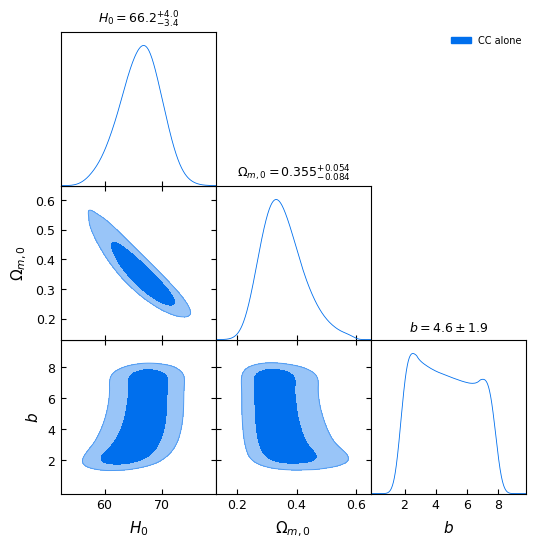

In [12]:
# =========================
# Corner plot using GetDist
# =========================

# Parameter names and LaTeX labels
param_names  = ["H0", "Omega_m0", "b"]
param_labels = [r"H_0", r"\Omega_{m,0}", r"b"]


# Create GetDist samples object
samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

# Smoothing and binning settings
samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})


# Parameter ranges (optional)
# samples.setRanges({
#     "param p1": (p1_min, p1_max),
#     "param p2": (p2_min, p2_max),
#     "param p3": (p3_min, p3_max)
# })


# Initialize GetDist subplot plotter
g = plots.get_subplot_plotter()

# Plot styling settings
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3


# Triangle (corner) plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["CC alone"],
    #contour_colors=["#"],
    title_limit=1
)

# Save figure
plt.savefig("triangle_AB_cc.png", dpi=300, bbox_inches="tight")
plt.show()